<a href="https://colab.research.google.com/github/JoDeMiro/Statistics/blob/main/Stat_for_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statisztikai mérések a MiCado Optimizerhez

Az adatok a JoDeMiro repositoriumból letölthetőek.

https://github.com/JoDeMiro/Data/tree/main/Micado

In [1]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 52 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv

--2022-01-27 16:47:15--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156914 (153K) [text/plain]
Saving to: ‘nn_training_data.csv’

nn_training_data.cs 100%[===================>] 153.24K  --.-KB/s    in 0.008s  

2022-01-27 16:47:15 (19.9 MB/s) - ‘nn_training_data.csv’ saved [156914/156914]



In [4]:
df = pd.read_csv('nn_training_data.csv')

In [5]:
df.head()

,timestamp,PktIn,KBIn,AVG_RR,Inter,CTXSW,KBOut,CPU,SUM_RR,PktOut,vm_number,AVG_LAT_05
0,1571923606,0.291658,0.029784,16.015706,5921.905442,3359.291450,0.439268,53.500884,64.076662,0.241660,5,466.25
1,1571923621,0.300010,0.030584,17.872610,5831.266601,3273.530409,0.440144,54.386839,71.507123,0.250011,5,457.25
2,1571923637,0.275005,0.029102,17.781137,5744.585008,3250.338397,0.443237,52.858070,71.124548,0.291673,5,433.25
3,1571923652,0.275002,0.029330,17.768750,5920.160015,3296.357451,0.440507,51.445648,71.075000,0.241668,5,410.25
4,1571923683,0.300004,0.030583,17.893865,6047.794644,3333.359290,0.440620,53.043713,71.575458,0.250001,5,429.25


In [6]:
X = df[['PktIn', 'PktOut', 'KBIn', 'KBOut', 'Inter', 'CTXSW', 'CPU', 'AVG_RR']]

X.head()

,PktIn,PktOut,KBIn,KBOut,Inter,CTXSW,CPU,AVG_RR
0,0.291658,0.241660,0.029784,0.439268,5921.905442,3359.291450,53.500884,16.015706
1,0.300010,0.250011,0.030584,0.440144,5831.266601,3273.530409,54.386839,17.872610
2,0.275005,0.291673,0.029102,0.443237,5744.585008,3250.338397,52.858070,17.781137
3,0.275002,0.241668,0.029330,0.440507,5920.160015,3296.357451,51.445648,17.768750
4,0.300004,0.250001,0.030583,0.440620,6047.794644,3333.359290,53.043713,17.893865


## Leíró statisztikák

In [7]:
X.describe()

,PktIn,PktOut,KBIn,KBOut,Inter,CTXSW,CPU,AVG_RR
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.281103,0.239509,0.029469,0.440826,4780.157328,3095.583565,37.262589,15.040358
std,0.016246,0.018822,0.000835,0.001835,1782.942636,1076.489579,14.487499,6.940871
min,0.249979,0.199993,0.028026,0.435483,552.975000,1151.625000,1.937500,0.000000
25%,0.270006,0.225005,0.028918,0.439750,3673.845000,2470.325207,31.551272,10.342845
50%,0.280000,0.237500,0.029394,0.440707,5069.877825,3082.632222,39.951490,16.099732
75%,0.290059,0.250000,0.029958,0.441698,6285.160916,3545.723749,47.989894,21.338542
max,0.400004,0.300006,0.036263,0.454762,8621.316667,10181.769327,69.287500,23.500000


## Timeline

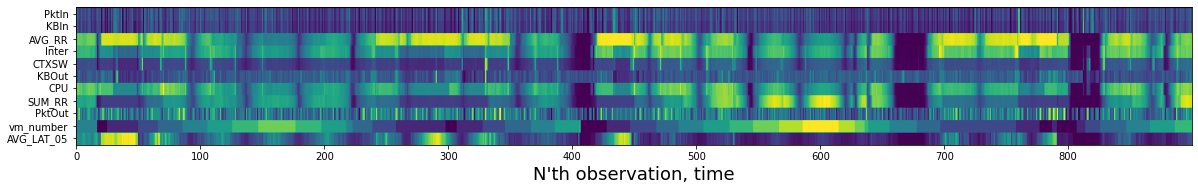

In [8]:
X = df.values

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

h = np.zeros((1, df.shape[0]))

for i, v in enumerate(df.columns):
  if( v != 'timestamp'):
    col = X_scaled[:,i]
    size = col.size
    col = col.reshape((1, col.size))
    col = col.T
    col = col.repeat(10, axis=0)
    col = col.reshape((size, 10))
    h = np.concatenate((h, col.T), axis=0)

# print(df.columns)
print('')
labels = df.columns[1:]
y = np.arange(5, 115, 10)
plt.figure(figsize=(20, 7))
plt.imshow(h)
plt.yticks(y, labels, rotation='horizontal')
plt.xlabel('N\'th observation, time', fontsize=18)
plt.show()

In [9]:
# gyors testzek a változókra

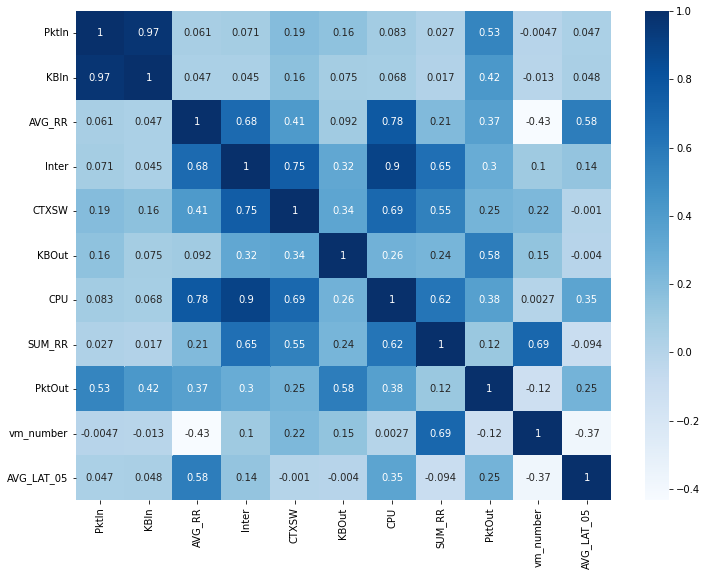

In [10]:
# korrelácó az egyes változók között
corr = df.iloc[: , 1:].corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.savefig('correlation_matrix1.png')
plt.show()

## Pearsons féle korreláció és hozzá tartozó p. érték

Ezt minden változópárra ki kell számolnom.

In [11]:
import scipy

scipy.stats.pearsonr(df['AVG_RR'], df['CPU'])

(0.7755417008895121, 1.395516854288729e-181)

## Correlációs mátrix

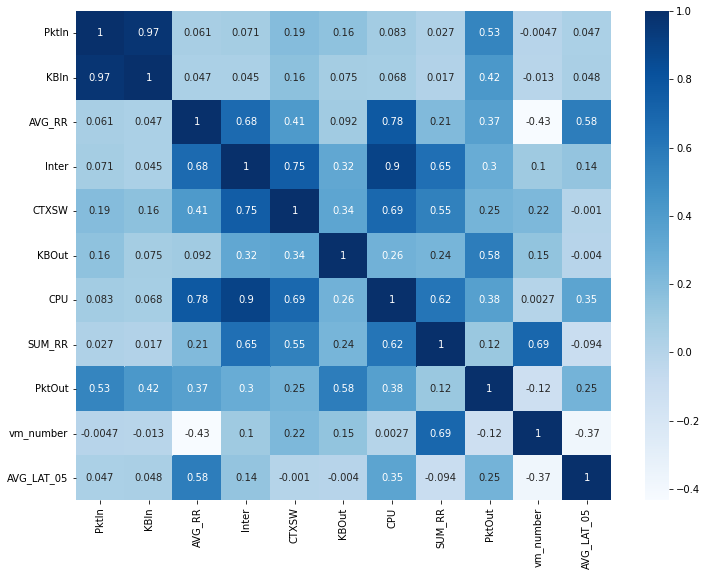

In [12]:
# korrelácó az egyes változók között
corr = df.iloc[: , 1:].corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.savefig('correlation_matrix.png')
plt.show()

## Idővonal

In [13]:
def timeline(variable, var_name, label):
  plt.figure(figsize=(20,4))
  plt.plot(variable, label=label)
  plt.ylabel(var_name, fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

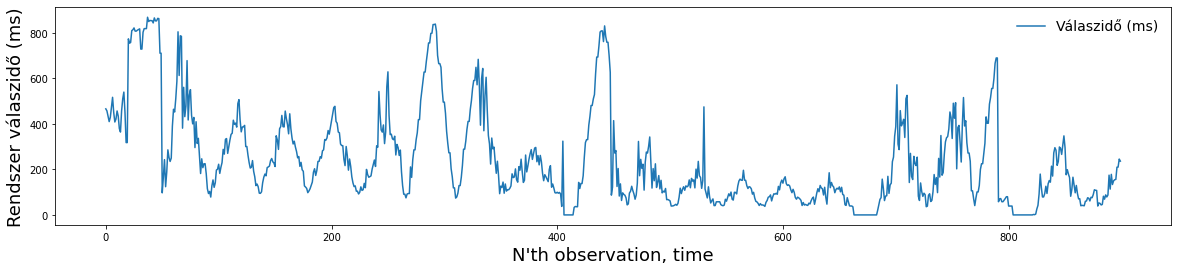

In [14]:
timeline(df['AVG_LAT_05'], 'Rendszer válaszidő (ms)', 'Válaszidő (ms)')

# df = df[df['AVG_LAT_05'] < 20000]
# timeline(df['AVG_LAT_05'])

No handles with labels found to put in legend.


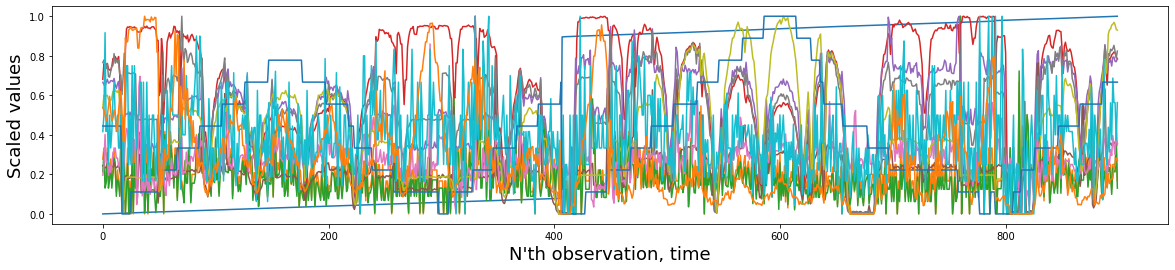

In [15]:
from sklearn.preprocessing import MinMaxScaler

df_scaler = MinMaxScaler((0,1))
df_scaled = df_scaler.fit_transform(df)

timeline(df_scaled, 'Scaled values', '')

No handles with labels found to put in legend.


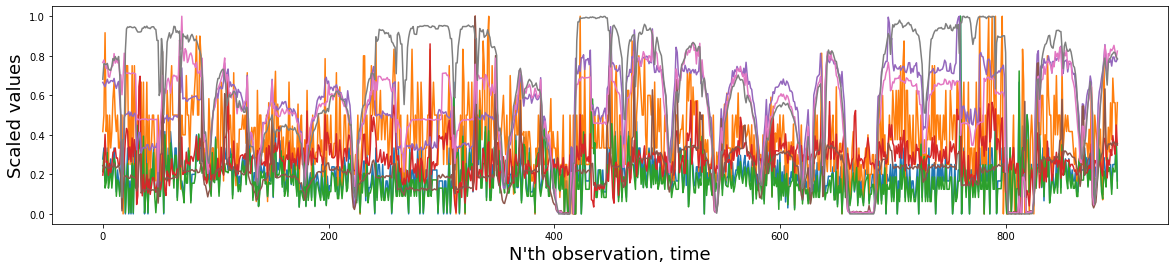

In [16]:
from sklearn.preprocessing import MinMaxScaler

X = df[['PktIn', 'PktOut', 'KBIn', 'KBOut', 'Inter', 'CTXSW', 'CPU', 'AVG_RR']]

X_scaler = MinMaxScaler((0,1))
X_scaled = df_scaler.fit_transform(X)

timeline(X_scaled, 'Scaled values', '')

# Before After vizsgálatok

In [17]:
# Keressük meg azokat az adatokat ahol változott a gépek száma

In [18]:
def createBeforeafterDF(df, lag, inputMetrics):
    beforeafterDF = df.copy()
    length = len(inputMetrics)
    # print(length)
    inputVariables = np.flip(beforeafterDF.columns[0:length].ravel(), axis=-1)
    # print('Input Variablels : ', inputVariables)

    index = length
    for i in inputVariables:
        new_column = beforeafterDF[i].shift(lag)
        new_column_name = (i + str(1)) # Todo: rename str(lag)
        beforeafterDF.insert(loc=index, column=new_column_name, value=new_column)

    beforeafterDF = beforeafterDF[lag:]

    return beforeafterDF

# Fontos
metrics = df.columns

# Before After adatok egy sorban
ba = createBeforeafterDF(df, 1, metrics)

# Csak azok az adatok ahol tényleges eltérés volt a gépek száma között
def createScalingDF(theBeforeAfterDF):
  new_beforeafterDF = theBeforeAfterDF.copy()
  scalingDF = new_beforeafterDF[new_beforeafterDF.vm_number != new_beforeafterDF.vm_number1]
  return scalingDF

fd = createScalingDF(ba)

rossz = fd.copy()

# Ki kell szűrni azokat az eseteket, ahol egynél több gépet adott hozzá, vagy vett el
fd['difference'] = fd['vm_number']-fd['vm_number1']
fd['abs_difference'] = abs(fd['difference'])
fd = fd[fd['abs_difference'] < 2]

print(fd.shape)

(46, 26)


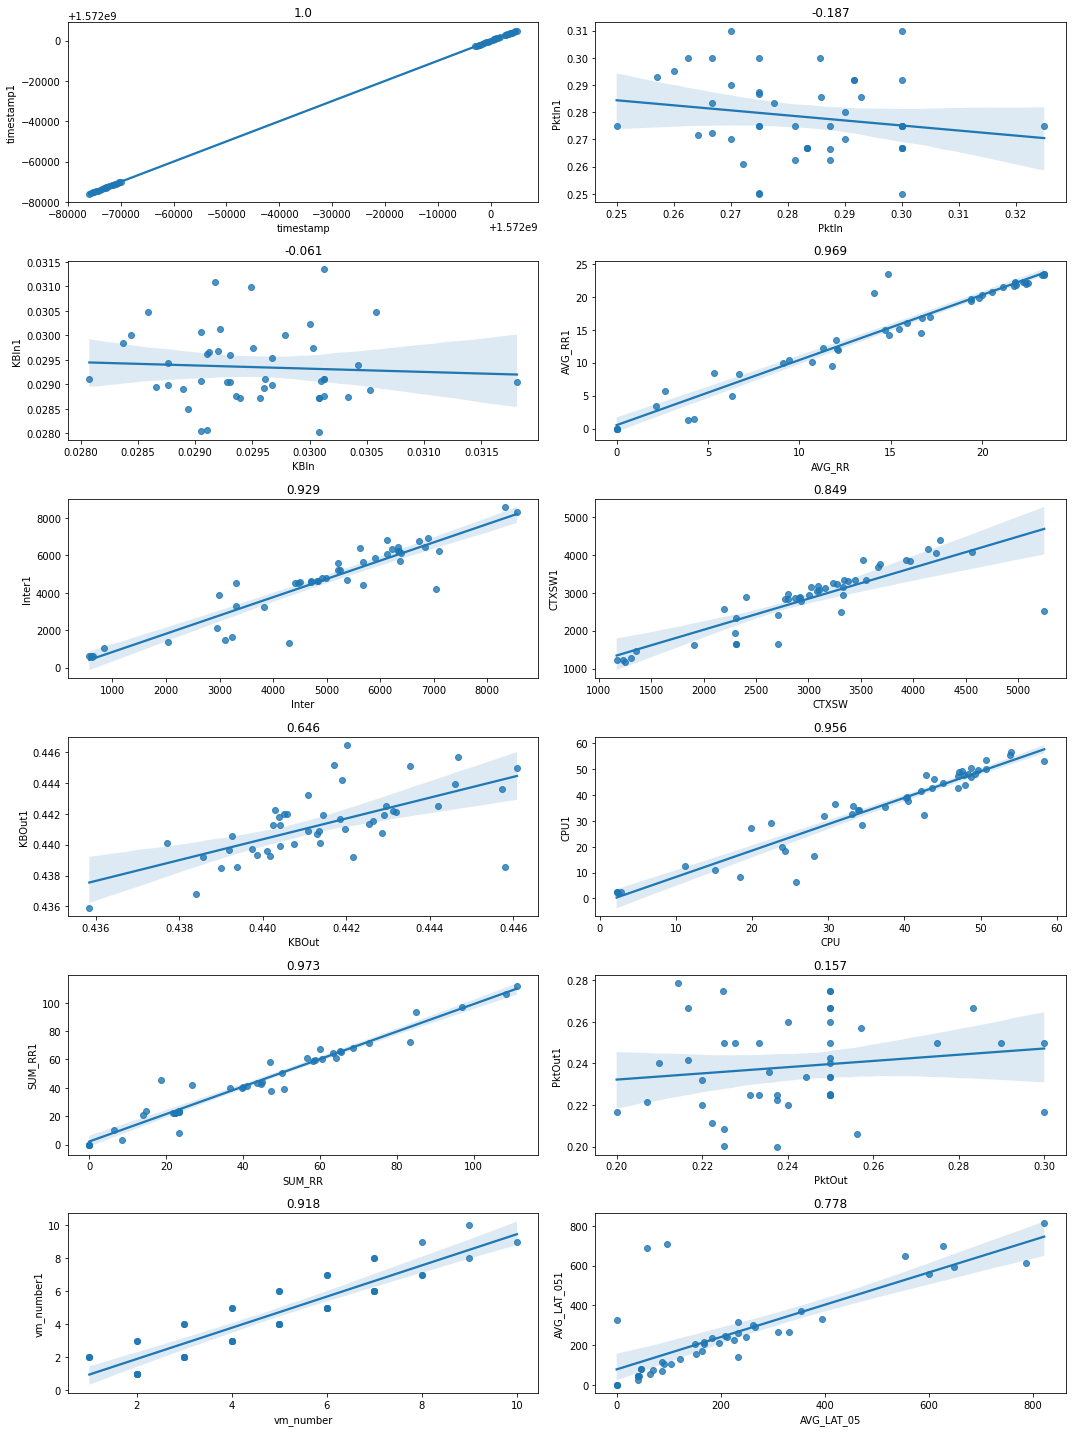

In [19]:
# Most nézzük meg, hogy milyen korreláció van az egyes before after változók között

fig, axes = plt.subplots(6, 2, figsize=(15, 20), sharey=False)
for j, i in enumerate(df.columns):
  corr = str(round(fd[i].corr(fd[i+'1']), 3))

  r = int(j/2)
  c = 1 if (j % 2 == 1) else 0
  sns.regplot(ax=axes[r, c], x = fd[i], y = fd[i+'1']).set_title(corr)

plt.tight_layout()
plt.show()

r2  =  0.9130603783494109
r2w =  0.913060378349411


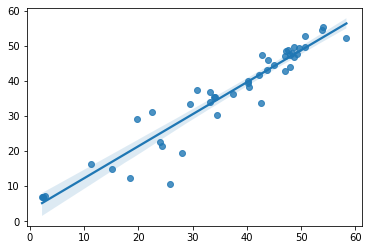

In [20]:
# Regresszió

y = fd['CPU'].values          # Current
x = fd['CPU1'].values         # Lag
x = x.reshape(-1,1)

regression = LinearRegression()

regression.fit(x,y)

y_pred = regression.predict(x)

r2  = r2_score(y, y_pred)
r2w = r2_score(y, y_pred, multioutput='variance_weighted')

print('r2  = ', r2)
print('r2w = ', r2w)

sns.regplot(y, y_pred)
plt.show()

In [21]:
fd.head()

,timestamp,PktIn,KBIn,AVG_RR,Inter,CTXSW,KBOut,CPU,SUM_RR,PktOut,vm_number,AVG_LAT_05,timestamp1,PktIn1,KBIn1,AVG_RR1,Inter1,CTXSW1,KBOut1,CPU1,SUM_RR1,PktOut1,vm_number1,AVG_LAT_051,difference,abs_difference
25,1571924040,0.250000,0.028076,22.225000,4706.025000,2929.825000,0.440576,49.687500,22.225000,0.225000,2,822.000000,1.571924e+09,0.275000,0.029102,22.275000,4556.650000,2777.225000,0.442017,49.762500,22.275000,0.250000,1.0,814.000000,1.0,1.0
50,1571924427,0.266667,0.028760,14.075352,3226.766667,2304.433333,0.438574,28.066667,14.075352,0.233333,3,97.000000,1.571924e+09,0.283329,0.029443,20.625516,1654.207794,1645.148154,0.439202,16.384957,20.625516,0.249997,2.0,711.000000,1.0,1.0
66,1571924676,0.262500,0.028589,21.762500,4499.175000,2780.387500,0.439868,47.200000,43.525000,0.250000,4,787.500000,1.571925e+09,0.300000,0.030469,21.586368,4555.662500,2841.700000,0.439319,48.906250,43.172735,0.250000,3.0,613.000000,1.0,1.0
86,1571925002,0.300003,0.030127,19.383168,5208.610141,3076.960783,0.442856,50.714869,58.149505,0.290003,5,207.666667,1.571925e+09,0.310006,0.031358,19.683333,5211.823825,3046.843006,0.440741,49.989613,59.050000,0.250005,4.0,246.666667,1.0,1.0
106,1571925313,0.291670,0.029786,17.174549,5672.416137,3273.460324,0.440510,49.260939,68.698198,0.250003,6,332.000000,1.571925e+09,0.291667,0.030013,16.956772,5658.550042,3236.323895,0.441976,47.997075,67.827088,0.266668,5.0,267.250000,1.0,1.0


r2_old  =  0.9211204911655055 	 r2w_old =  0.9211204911655055
r2_new  =  0.9131056356208895 	 r2w_new =  0.9131056356208895


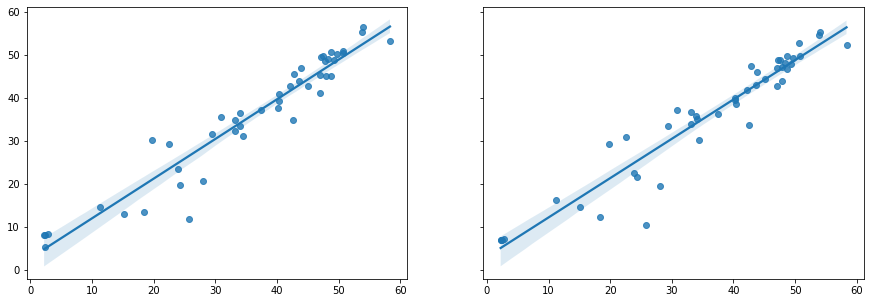

In [22]:
# Regresszió

# A 'vm_number' változót is figyelembe vesszük

y     = fd['CPU'].values          # Current
x_old = fd[['CPU1', 'vm_number1', 'difference']].values
x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051']].values

x_new = fd[['CPU1', 'PktIn1']].values

regression = LinearRegression()

# fit old
regression.fit(x_old, y)
y_pred_old = regression.predict(x_old)
r2_old  = r2_score(y, y_pred_old)
r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

# fit new
regression.fit(x_new, y)
y_pred_new = regression.predict(x_new)
r2_new  = r2_score(y, y_pred_new)
r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')


print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(ax=axes[0], x = y, y = y_pred_old)
sns.regplot(ax=axes[1], x = y, y = y_pred_new)
plt.show()

timestamp
r2_old  =  0.9999992516679015 	 r2w_old =  0.9999992516679015
r2_lat  =  0.4462655887460021 	 r2w_lat =  0.4462655887460021
r2_new  =  0.5420109630020147 	 r2w_new =  0.5420109630020147


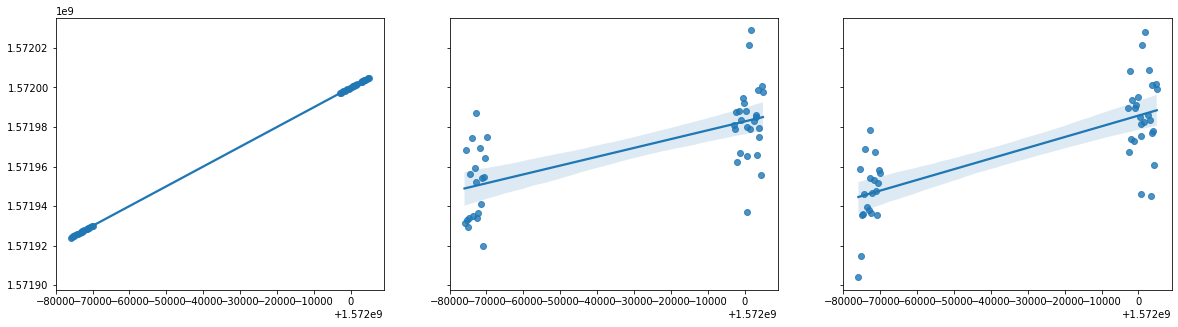

PktIn
r2_old  =  0.10705442505705887 	 r2w_old =  0.10705442505705887
r2_lat  =  0.34146768318633003 	 r2w_lat =  0.34146768318633003
r2_new  =  0.3910216059652205 	 r2w_new =  0.3910216059652205


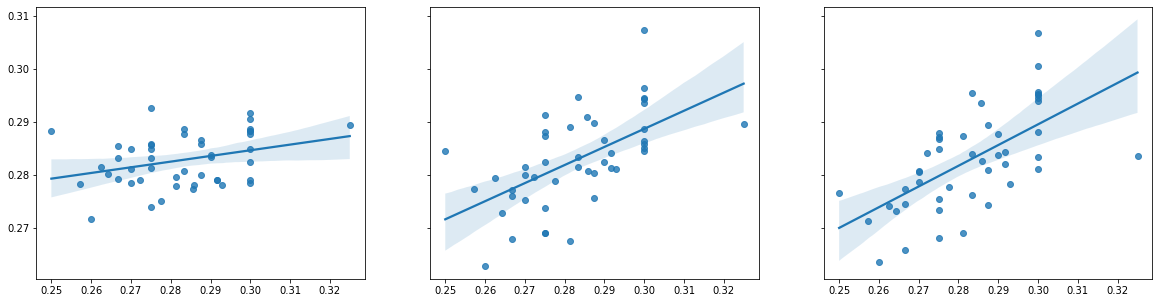

KBIn
r2_old  =  0.08974145580582782 	 r2w_old =  0.08974145580582782
r2_lat  =  0.2884613409819412 	 r2w_lat =  0.2884613409819412
r2_new  =  0.3124750536556792 	 r2w_new =  0.3124750536556792


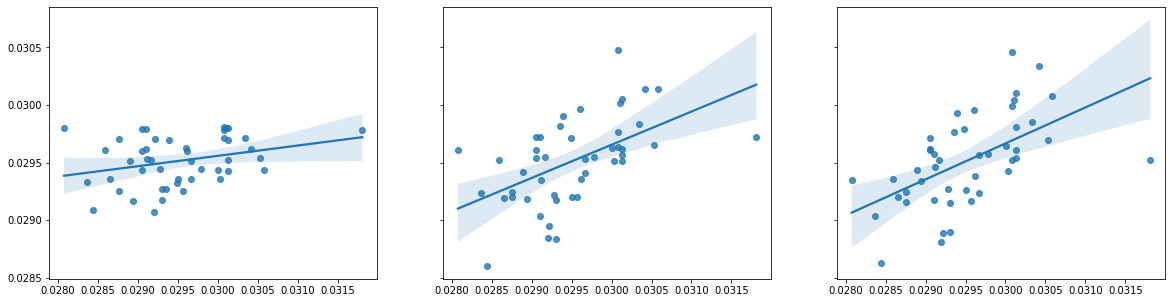

AVG_RR
r2_old  =  0.9476628615627488 	 r2w_old =  0.9476628615627488
r2_lat  =  0.9629925184328042 	 r2w_lat =  0.9629925184328043
r2_new  =  0.9646396758488164 	 r2w_new =  0.9646396758488164


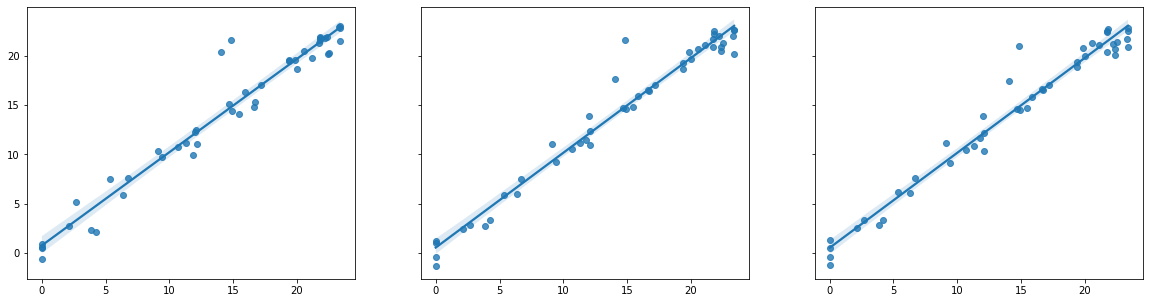

Inter
r2_old  =  0.865901238436938 	 r2w_old =  0.865901238436938
r2_lat  =  0.8914325304998093 	 r2w_lat =  0.8914325304998093
r2_new  =  0.8936824407594071 	 r2w_new =  0.8936824407594071


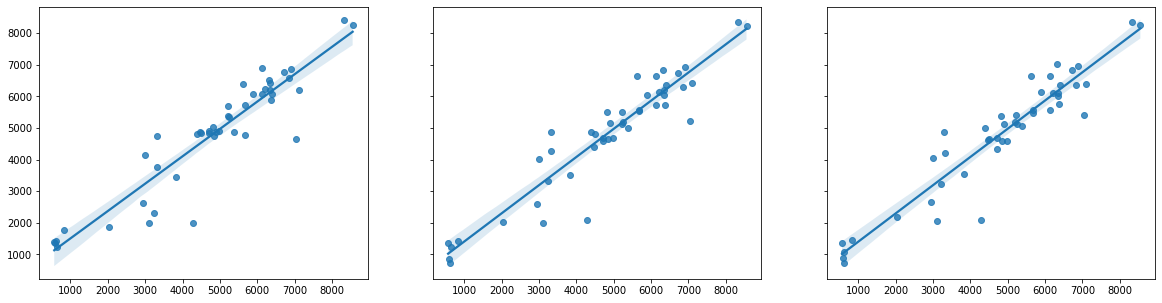

CTXSW
r2_old  =  0.7242471911087963 	 r2w_old =  0.7242471911087963
r2_lat  =  0.8035543286795042 	 r2w_lat =  0.8035543286795042
r2_new  =  0.8054839786666157 	 r2w_new =  0.8054839786666157


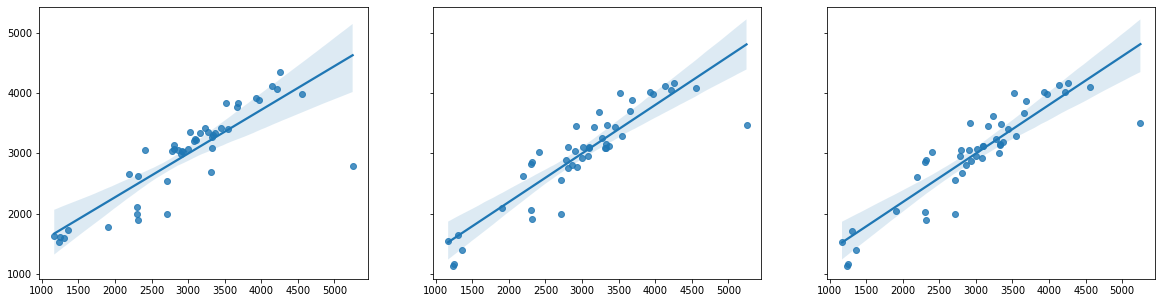

KBOut
r2_old  =  0.5767717516312963 	 r2w_old =  0.5767717516312963
r2_lat  =  0.7532081362490397 	 r2w_lat =  0.7532081362490398
r2_new  =  0.7708709111488791 	 r2w_new =  0.7708709111488791


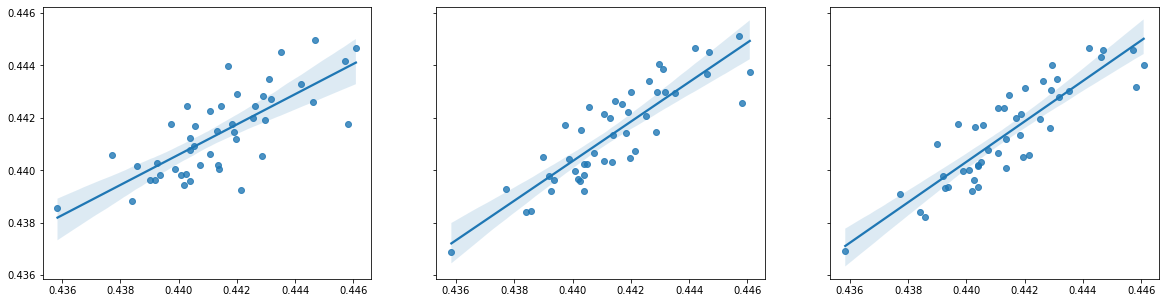

CPU
r2_old  =  0.9211204911655055 	 r2w_old =  0.9211204911655055
r2_lat  =  0.9392319836476576 	 r2w_lat =  0.9392319836476576
r2_new  =  0.9392324247754388 	 r2w_new =  0.9392324247754388


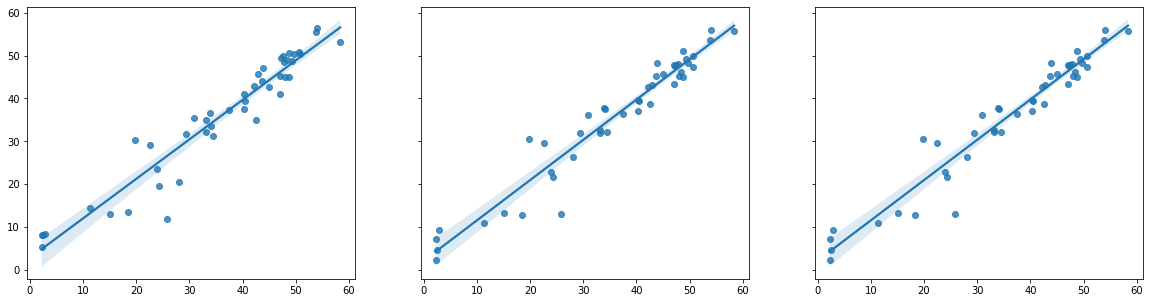

SUM_RR
r2_old  =  0.9582875583310523 	 r2w_old =  0.9582875583310523
r2_lat  =  0.9769662684077801 	 r2w_lat =  0.9769662684077801
r2_new  =  0.9772262753472183 	 r2w_new =  0.9772262753472184


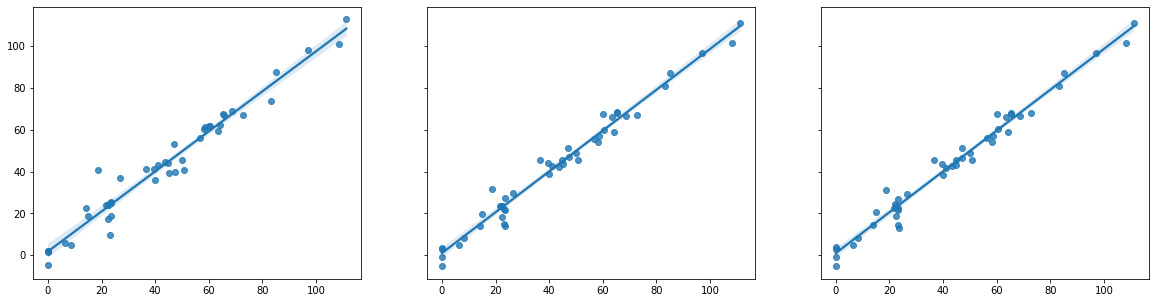

PktOut
r2_old  =  0.18778127550405532 	 r2w_old =  0.18778127550405532
r2_lat  =  0.5002717790882818 	 r2w_lat =  0.5002717790882818
r2_new  =  0.5323782713862962 	 r2w_new =  0.5323782713862962


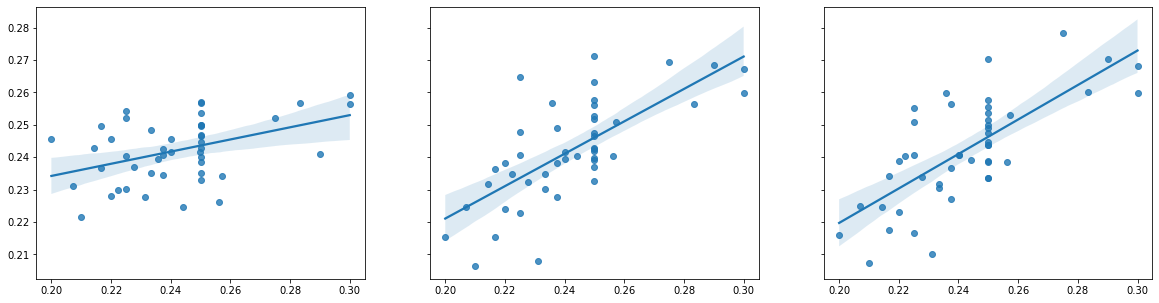

vm_number
r2_old  =  1.0 	 r2w_old =  1.0
r2_lat  =  1.0 	 r2w_lat =  1.0
r2_new  =  1.0 	 r2w_new =  1.0


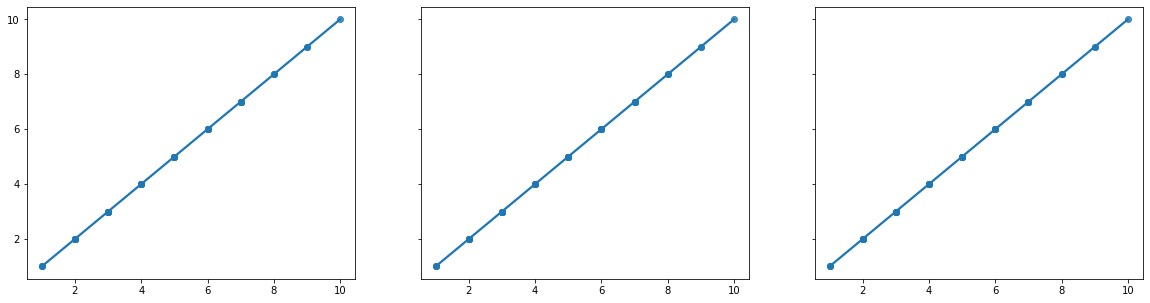

AVG_LAT_05
r2_old  =  0.6133918475071771 	 r2w_old =  0.6133918475071771
r2_lat  =  0.498189142729043 	 r2w_lat =  0.498189142729043
r2_new  =  0.6785585221690495 	 r2w_new =  0.6785585221690495


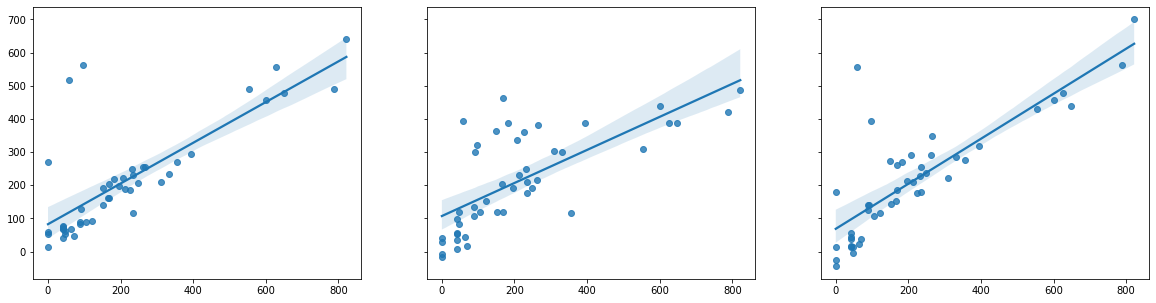

In [23]:
# Regresszió
for i in df.columns:
  y     = fd[i].values               # Current
  x_old = fd[[str( i + '1' ), 'vm_number1', 'difference']].values
  x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'difference', 'AVG_LAT_051']].values
  x_lat = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'difference']].values


  regression = LinearRegression()

  # fit old
  regression.fit(x_old, y)
  y_pred_old = regression.predict(x_old)
  r2_old  = r2_score(y, y_pred_old)
  r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

  # fit new
  regression.fit(x_new, y)
  y_pred_new = regression.predict(x_new)
  r2_new  = r2_score(y, y_pred_new)
  r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')

  # fit without latency
  regression.fit(x_lat, y)
  y_pred_lat = regression.predict(x_lat)
  r2_lat  = r2_score(y, y_pred_lat)
  r2w_lat = r2_score(y, y_pred_lat, multioutput='variance_weighted')



  print(i)
  print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
  print('r2_lat  = ', r2_lat, '\t', 'r2w_lat = ', r2w_lat)
  print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


  fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
  sns.regplot(ax=axes[0], x = y, y = y_pred_old)
  sns.regplot(ax=axes[1], x = y, y = y_pred_lat)
  sns.regplot(ax=axes[2], x = y, y = y_pred_new)
  # plt.savefig('before_after.png')
  plt.show()

## # NN, a request rate nélkül

In [24]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [25]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=1000,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=20,
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.7565453965382479
r2 test  =  0.5865526073492766


## Helper függvények

In [26]:
#@title
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def save_mlp(name):
  filename = name
  pickle.dump(mlp, open(filename, 'wb'))

def load_mlp(name):
  mlp = pickle.load(open(filename, 'rb'))
  return mlp

def timeline_plot(real, estimated):
  plt.figure(figsize=(20, 6))
  plt.plot(real, label = 'Real')
  plt.plot(estimated, label = 'Estimated')
  plt.title('Estimated vs Real values', fontsize=18)
  plt.ylabel('Average Latency - Normalized', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  a1.scatter(y_train, y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  a2.scatter(y_test, y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  sns.regplot(ax=a1, x = y_train, y = y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  a1.set_ylim(-0.05, 1.05)
  a1.set_xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  sns.regplot(ax=a2, x = y_test, y = y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  a2.set_ylim(-0.05, 1.05)
  a2.set_xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummulative_plots(errors, cummulative_errors, y_real, y_predicted):
  plt.figure(figsize=(20,4))
  plt.plot(errors, label='Error per estimation')
  plt.ylabel('Error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(cummulative_errors, label='Cummulative error')
  plt.ylabel('Cumulative error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(y_predicted, label='predicted')
  plt.plot(y_real, label='real')
  plt.ylabel('Average Latency', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def cummaulative_real_predicted_scatter(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  plt.scatter(y_real, y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummaulative_real_predicted_scatter_sns(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  sns.regplot(x = y_real, y = y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  plt.ylim(-0.05, 1.05)
  plt.xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def timeline(variable):
  plt.figure(figsize=(20,4))
  plt.plot(variable, label='Timeseries')
  plt.ylabel('Value', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

## Helper DrawNN

In [27]:
#@title
from matplotlib import pyplot
from math import cos, sin, atan
from palettable.tableau import Tableau_10
from time import localtime, strftime
import numpy as np

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, id=-1, name=None):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)
        pyplot.gca().text(self.x, self.y-0.15, str(id), size=10, ha='center')
        if name is not None:
          pyplot.gca().text(self.x+0.05, self.y-0.5, str(name), size=20, ha='center', va='top', rotation='vertical')

class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer, input_names=None):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.input_names = input_names

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, weight=0.4, textoverlaphandler=None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)

        # assign colors to lines depending on the sign of the weight
        color=Tableau_10.mpl_colors[0]
        if weight > 0: color=Tableau_10.mpl_colors[1]

        # assign different linewidths to lines depending on the size of the weight
        abs_weight = abs(weight)        
        if abs_weight > 0.5: 
            linewidth = 5*abs_weight
        elif abs_weight > 0.8: 
            linewidth =  50*abs_weight
        else:
            linewidth = abs_weight

        # draw the weights and adjust the labels of weights to avoid overlapping
        if abs_weight > 0.5: 
            # while loop to determine the optimal locaton for text lables to avoid overlapping
            index_step = 2
            num_segments = 10   
            txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
            txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments
            while ((not textoverlaphandler.getspace([txt_x_pos-0.5, txt_y_pos-0.5, txt_x_pos+0.5, txt_y_pos+0.5])) and index_step < num_segments):
                index_step = index_step + 1
                txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
                txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments

            # print("Label positions: ", "{:.2f}".format(txt_x_pos), "{:.2f}".format(txt_y_pos), "{:3.2f}".format(weight))
            a=pyplot.gca().text(txt_x_pos, txt_y_pos, "{:3.2f}".format(weight), size=12, ha='center')
            a.set_bbox(dict(facecolor='white', alpha=0))
            # print(a.get_bbox_patch().get_height())

        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment), linewidth=linewidth, color=color)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, weights=None, textoverlaphandler=None):
        j=0 # index for neurons in this layer
        z=0 # counter for names
        for neuron in self.neurons:            
            i=0 # index for neurons in previous layer
            if(layerType==0):
              name = self.input_names[z]
              neuron.draw( self.neuron_radius, id=j+1, name=name)
            else:
              neuron.draw( self.neuron_radius, id=j+1)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weights[i,j], textoverlaphandler)
                    i=i+1
            j=j+1
            z=z+1
        
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

# A class to handle Text Overlapping
# The idea is to first create a grid space, if a grid is already occupied, then
# the grid is not available for text labels.
class TextOverlappingHandler():
    # initialize the class with the width and height of the plot area
    def __init__(self, width, height, grid_size=0.2):
        self.grid_size = grid_size
        self.cells = np.ones((int(np.ceil(width / grid_size)), int(np.ceil(height / grid_size))), dtype=bool)

    # input test_coordinates(bottom left and top right), 
    # getspace will tell you whether a text label can be put in the test coordinates
    def getspace(self, test_coordinates):
        x_left_pos = int(np.floor(test_coordinates[0]/self.grid_size))
        y_botttom_pos = int(np.floor(test_coordinates[1]/self.grid_size))
        x_right_pos = int(np.floor(test_coordinates[2]/self.grid_size))
        y_top_pos = int(np.floor(test_coordinates[3]/self.grid_size))
        if self.cells[x_left_pos, y_botttom_pos] and self.cells[x_left_pos, y_top_pos] \
        and self.cells[x_right_pos, y_top_pos] and self.cells[x_right_pos, y_botttom_pos]:
            for i in range(x_left_pos, x_right_pos):
                for j in range(y_botttom_pos, y_top_pos):
                    self.cells[i, j] = False

            return True
        else:
            return False

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer, input_names=None):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0
        self.input_names = []
        if (input_names == None):
            self.input_names = []
        else:
            self.input_names = input_names

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer, self.input_names)
        self.layers.append(layer)

    def draw(self, weights_list=None, input_names=None):
        # vertical_distance_between_layers and horizontal_distance_between_neurons are the same with the variables of the same name in layer class
        vertical_distance_between_layers = 6
        horizontal_distance_between_neurons = 2
        overlaphandler = TextOverlappingHandler(\
            self.number_of_neurons_in_widest_layer*horizontal_distance_between_neurons,\
            len(self.layers)*vertical_distance_between_layers, grid_size=0.2 )

        if( len(self.input_names) <= 10 ):
          pyplot.figure(figsize=(12, 9))
        elif( len(self.input_names) > 10 ):
          pyplot.figure(figsize=(24, 10))
        else:
          pyplot.figure(figsize=(12,9))
        for i in range( len(self.layers) ):
            layer = self.layers[i]                                
            if i == 0:
                layer.draw( layerType=0 )
            elif i == len(self.layers)-1:
                layer.draw( layerType=-1, weights=weights_list[i-1], textoverlaphandler=overlaphandler)
            else:
                layer.draw( layerType=i, weights=weights_list[i-1], textoverlaphandler=overlaphandler)

        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        figureName='ANN_'+strftime("%Y%m%d_%H%M%S", localtime())+'.png'
        pyplot.savefig(figureName, dpi=300, bbox_inches="tight")
        pyplot.show()

class DrawNN():
    # para: neural_network is an array of the number of neurons 
    # from input layer to output layer, e.g., a neural network of 5 nerons in the input layer, 
    # 10 neurons in the hidden layer 1 and 1 neuron in the output layer is [5, 10, 1]
    # para: weights_list (optional) is the output weights list of a neural network which can be obtained via classifier.coefs_
    def __init__( self, neural_network, weights_list=None, input_names=None ):
        # self.input_names = input_names
        self.neural_network = neural_network
        self.weights_list = weights_list
        # if input_names exists
        if input_names is None:
          self.input_names = []
        else:
          self.input_names = input_names
        # if weights_list is none, then create a uniform list to fill the weights_list
        if weights_list is None:
            weights_list=[]
            for first, second in zip(neural_network, neural_network[1:]):
                tempArr = np.ones((first, second))*0.4
                weights_list.append(tempArr)
            self.weights_list = weights_list
        
    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer, self.input_names)
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(self.weights_list)

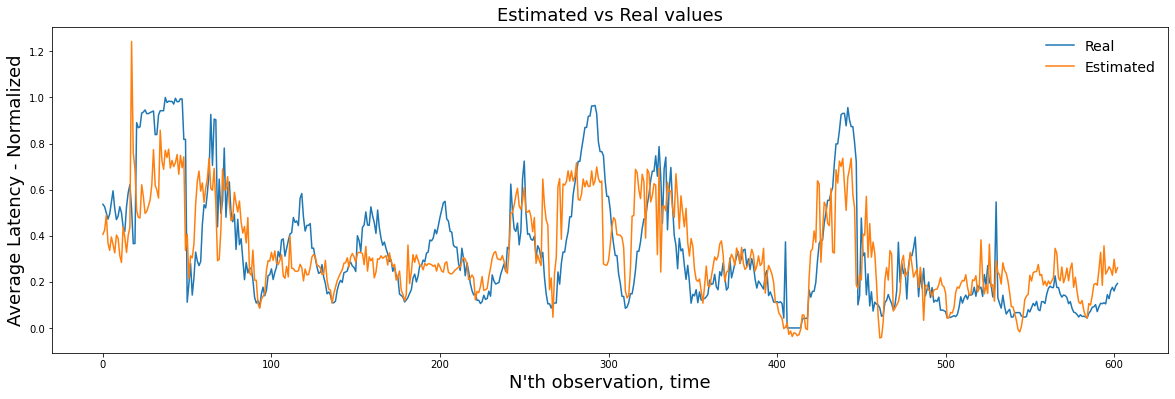

In [28]:
timeline_plot(y_train, y_pred_train)

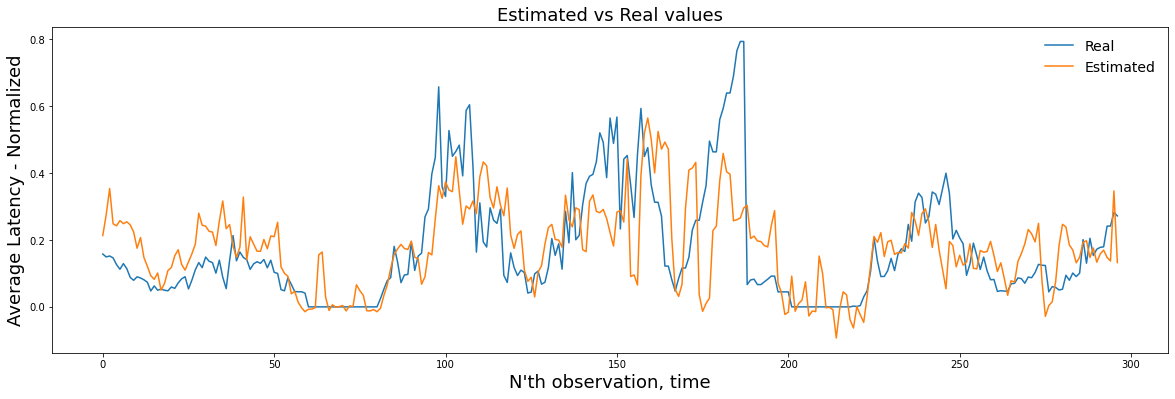

In [29]:
timeline_plot(y_test, y_pred_test)

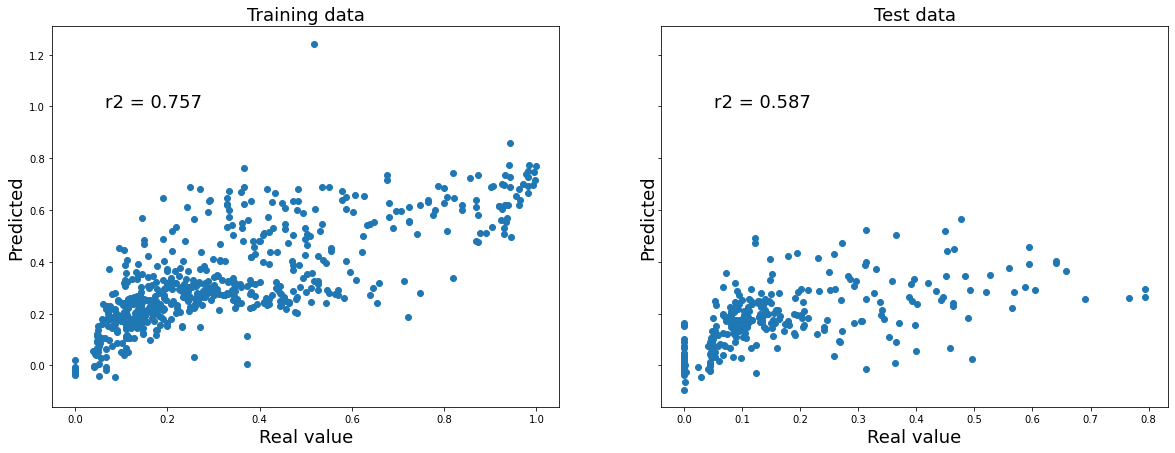

In [30]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

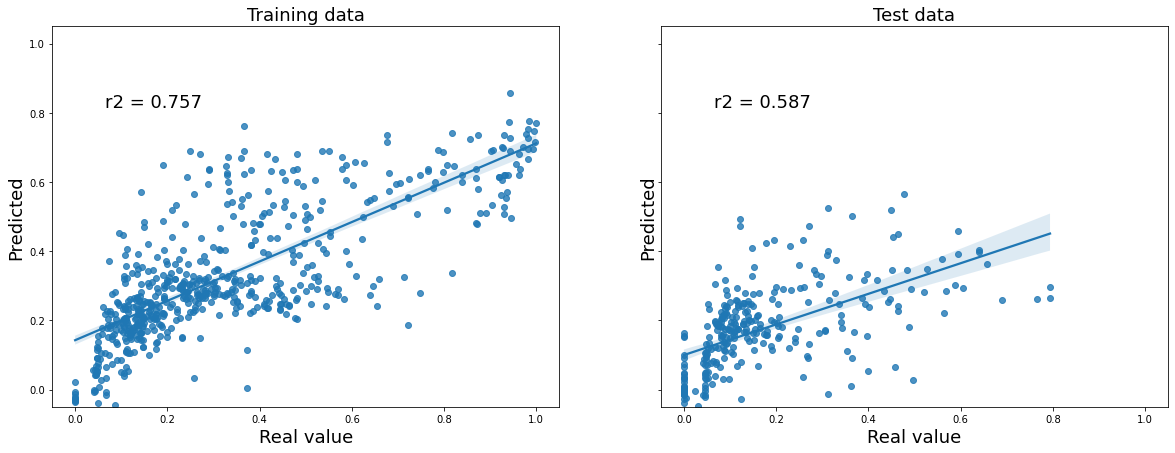

In [31]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

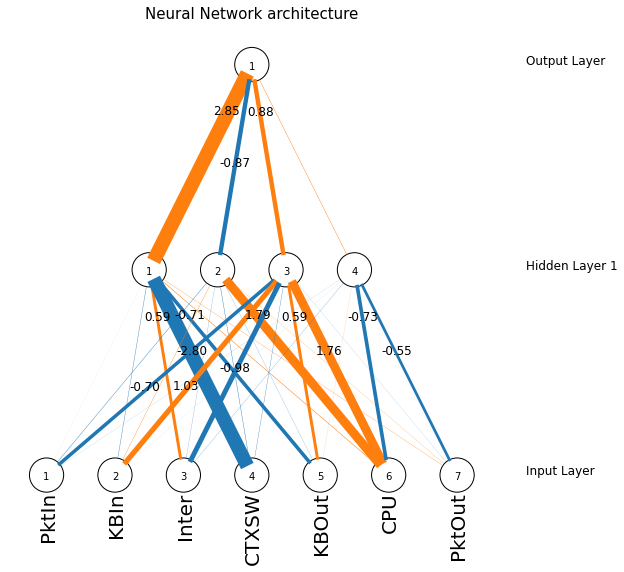

In [32]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

## # NN request rate nélkül laggal

In [33]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [34]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=4,
                           max_iter=1000,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=2000,
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.6702075334964429
r2 test  =  0.45303357330152333


In [35]:
load = False
model = '2_model.sav'
if (load == True):
  mlp = load_mplp(model)
else:
  save_mlp(model)

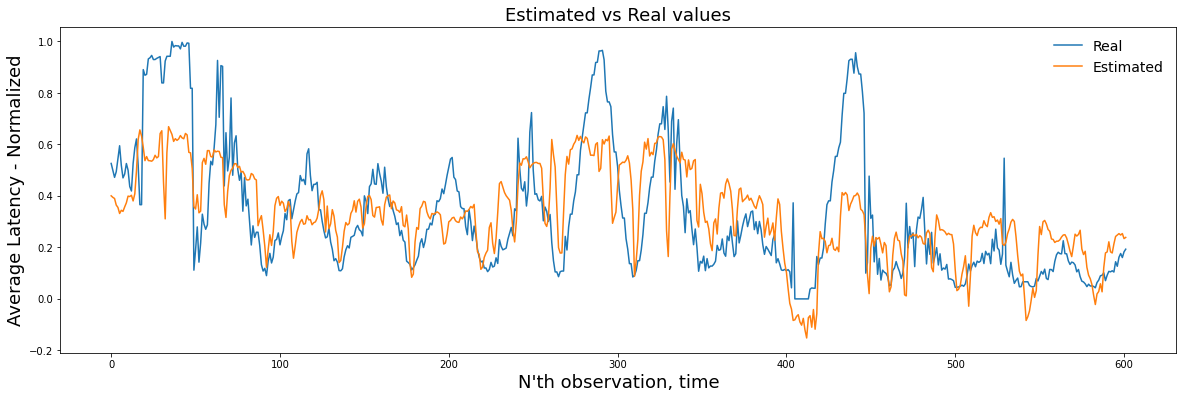

In [36]:
timeline_plot(y_train, y_pred_train)

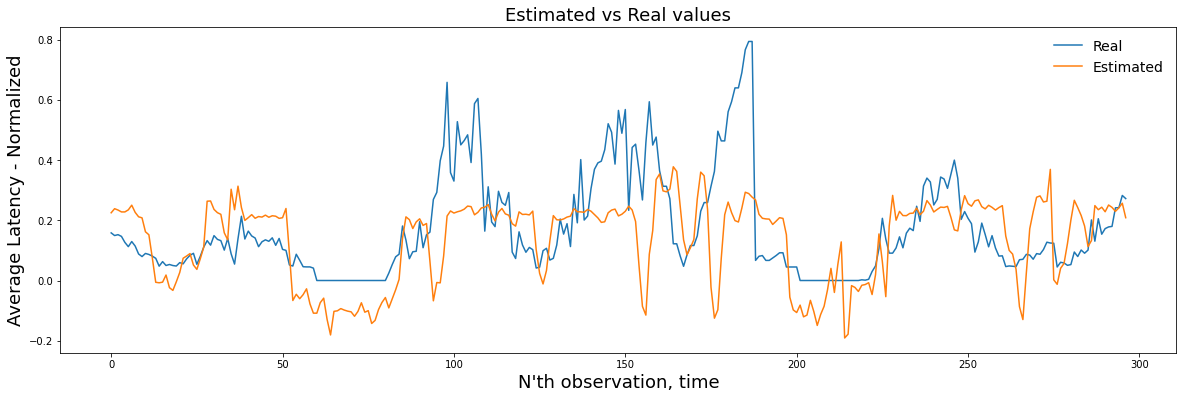

In [37]:
timeline_plot(y_test, y_pred_test)

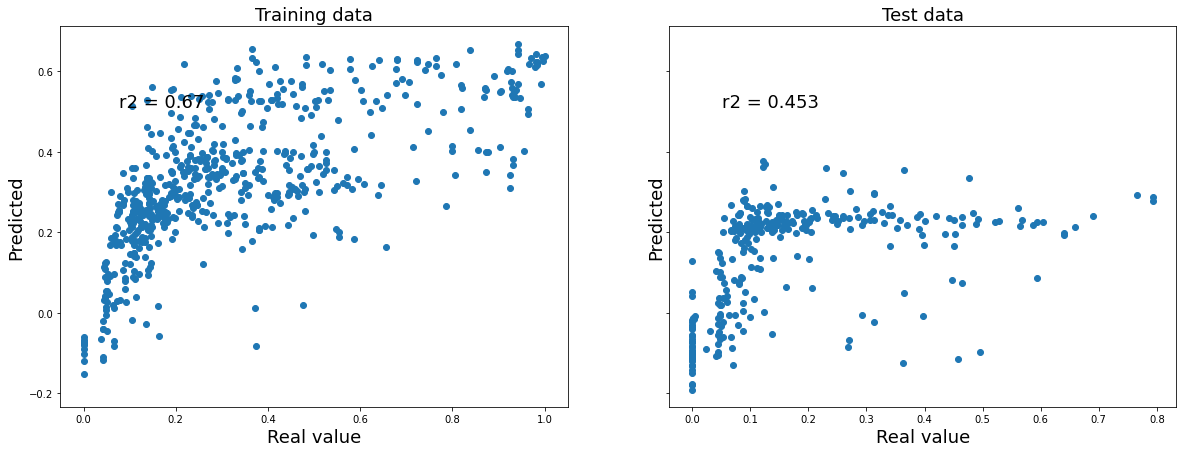

In [38]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

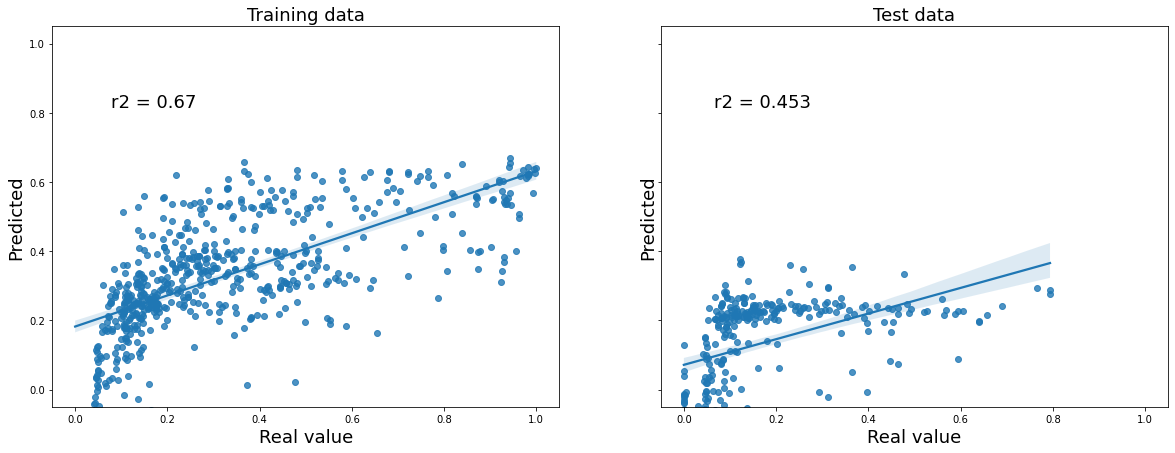

In [39]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

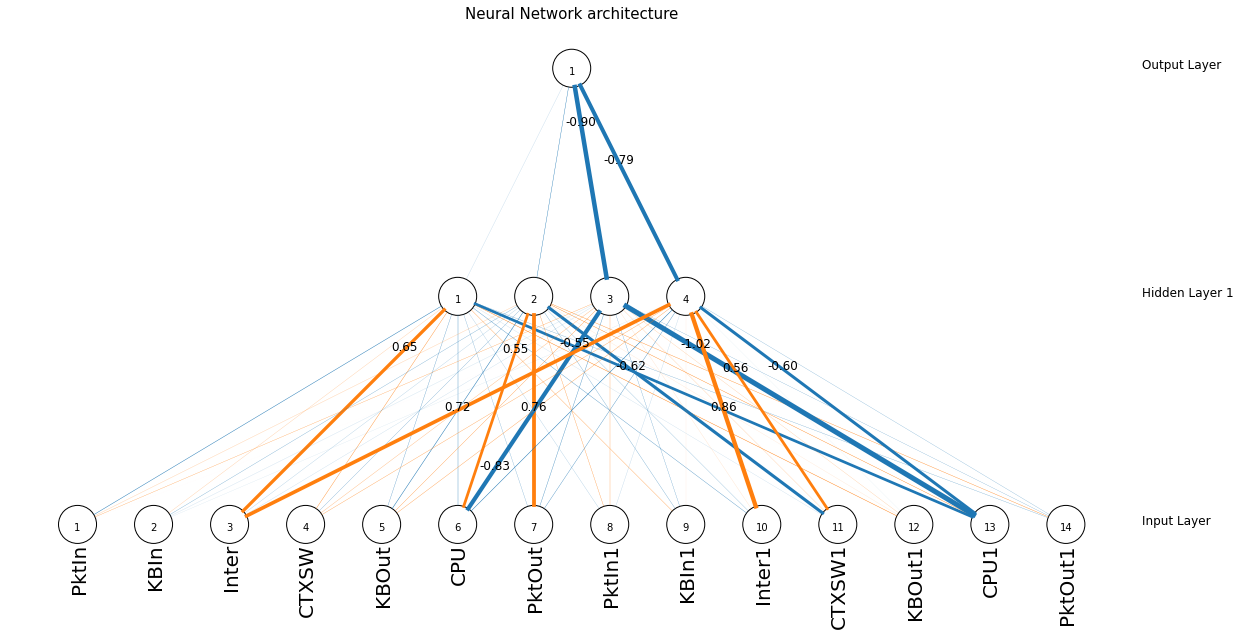

In [40]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

## # NN request rate nélkül laggal összetettem neurális hálóval

In [41]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [77]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'tanh'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=1000,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=2000,
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

A_model_error_normalized = y_pred_train - y_train.ravel()
A_model_error = min_max_scaler.inverse_transform(y_pred_train.reshape(-1,1)) - min_max_scaler.inverse_transform(y_train)
A_model_error = A_model_error.ravel()
A_model_y_normalized = y_train.ravel()
A_model_y = min_max_scaler.inverse_transform(y_train).ravel()
A_model_predicted_y_normalized = y_pred_train.ravel()
A_model_predicted_y = min_max_scaler.inverse_transform(y_pred_train.reshape(-1,1)).ravel()


r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8904775132810387
r2 test  =  0.650131434229005


In [43]:
model = '3_model.sav'
if (load == True):
  mlp = load_mplp(model)
else:
  save_mlp(model)

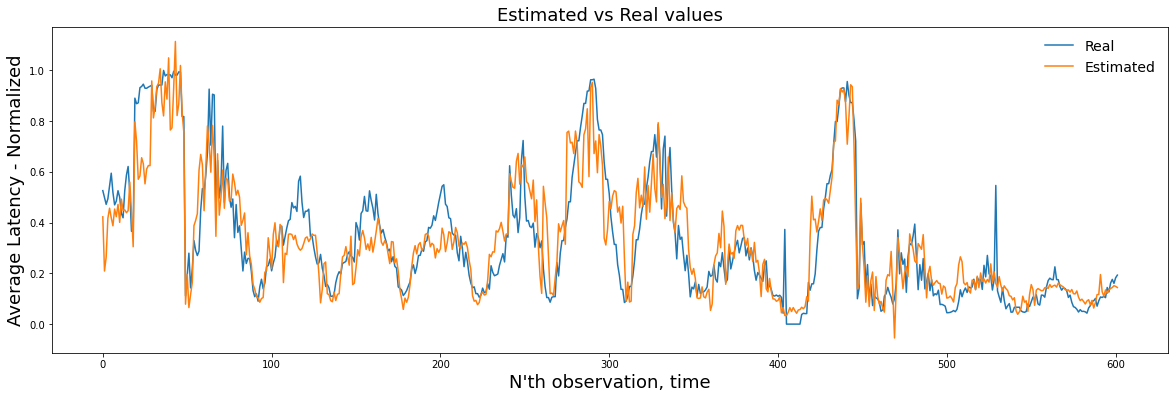

In [44]:
timeline_plot(y_train, y_pred_train)

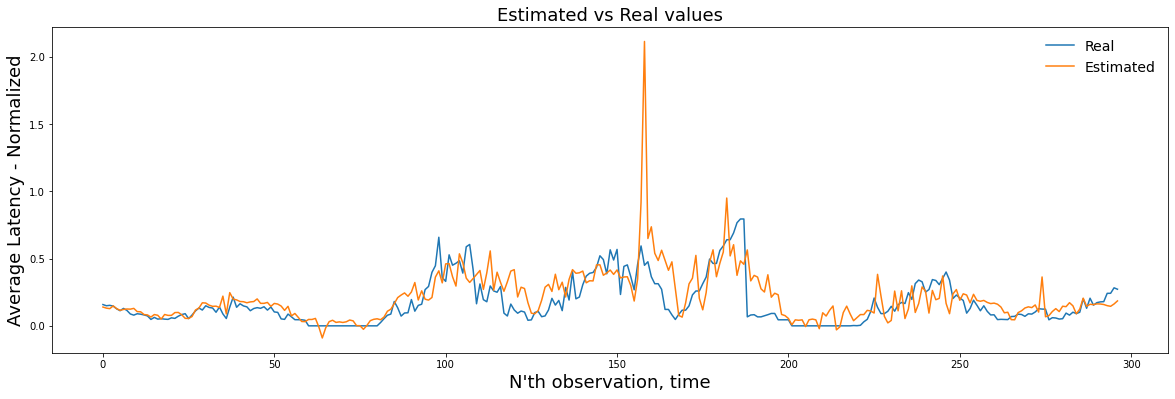

In [45]:
timeline_plot(y_test, y_pred_test)

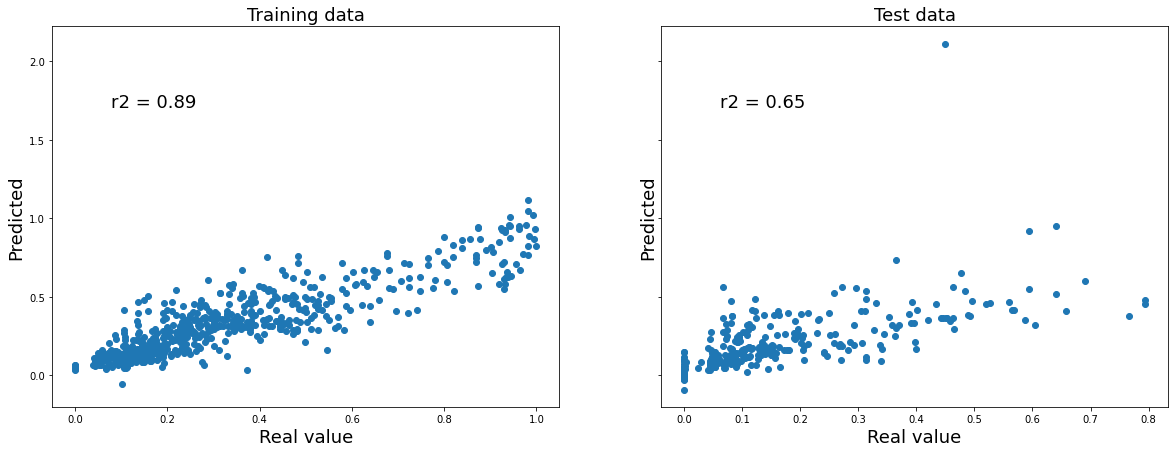

In [46]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

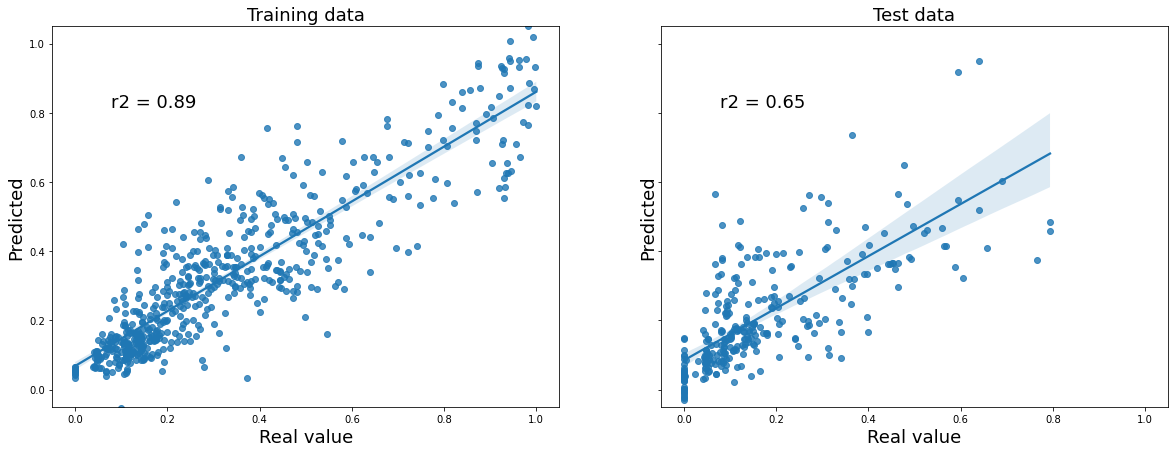

In [47]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

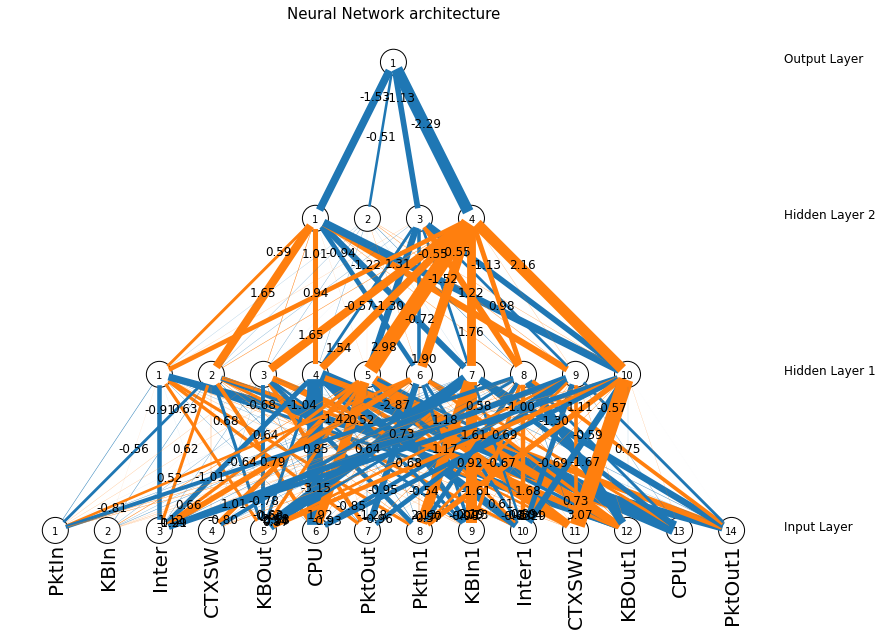

In [48]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

## # NN, lag nélkül és laggal

In [49]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [71]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=2000,
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)
B_model_error_normalized = y_pred_train - y_train.ravel()
B_model_error = min_max_scaler.inverse_transform(y_pred_train.reshape(-1,1)) - min_max_scaler.inverse_transform(y_train)
B_model_error = B_model_error.ravel()
B_model_y_normalized = y_train.ravel()
B_model_y = min_max_scaler.inverse_transform(y_train).ravel()
B_model_predicted_y_normalized = y_pred_train.ravel()
B_model_predicted_y = min_max_scaler.inverse_transform(y_pred_train.reshape(-1,1)).ravel()

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

(603,)
(603,)
r2 train =  0.892536492236413
r2 test  =  0.6024888389804552


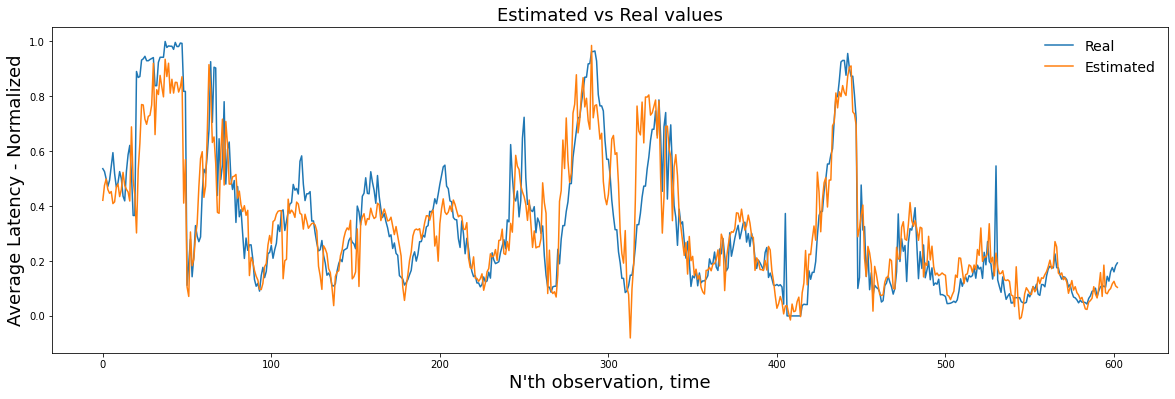

In [141]:
timeline_plot(y_train, y_pred_train)

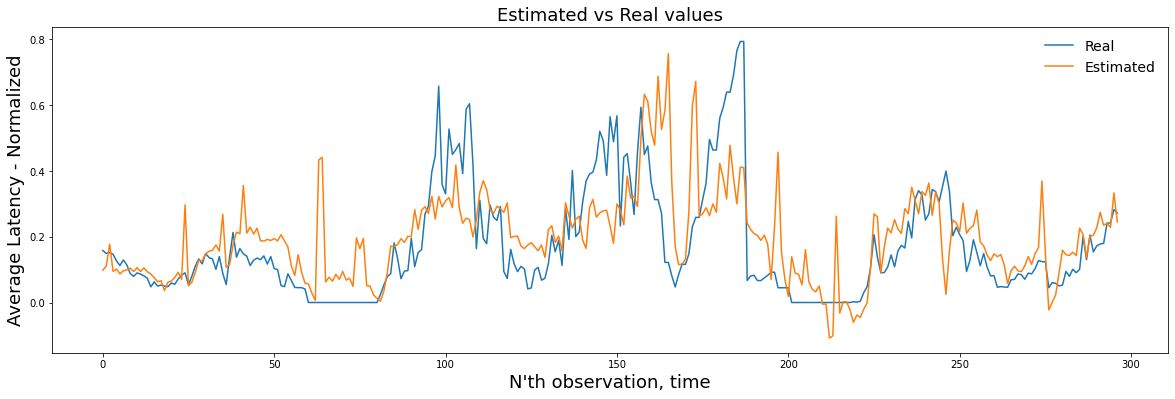

In [142]:
timeline_plot(y_test, y_pred_test)

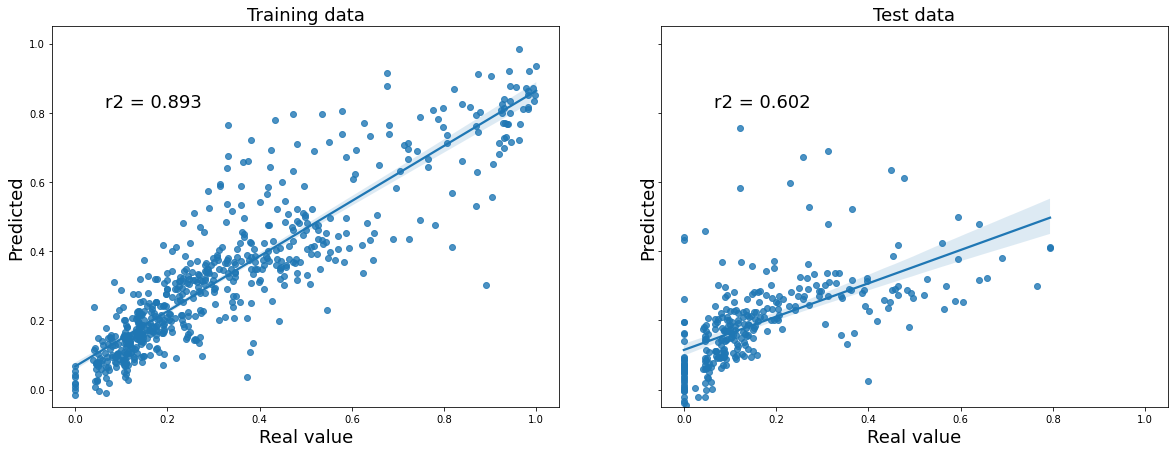

In [143]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

# Statisztka a szimulációs adatokon

In [144]:
!wget https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/AB_Method_Scale.csv

--2022-01-27 09:56:02--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/AB_Method_Scale.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10018 (9.8K) [text/plain]
Saving to: ‘AB_Method_Scale.csv.1’

AB_Method_Scale.csv 100%[===================>]   9.78K  --.-KB/s    in 0s      

2022-01-27 09:56:03 (81.4 MB/s) - ‘AB_Method_Scale.csv.1’ saved [10018/10018]



In [145]:
ab_stat_scale_db = pd.read_csv('AB_Method_Scale.csv', sep=';')

In [146]:
ab_stat_scale_db.head(3)

,Method,Action
0,0,1
1,0,0
2,0,0


$$ \chi^{2} = \sum_{i=1}^{k} \frac{(x_i - m_i)^2}{m_i}$$

$$ \chi_{1}^{2} = \frac{(783 - 805)^2}{805} + \frac{(827 - 805)^2}{805} + \frac{(217 - 195)^2}{195} + \frac{(173 - 195)^2}{195} = 6.1665 $$

# Adatok generálása

Csak a próba kedvért két "futás" összehasolítása.

Itt az egyik a valós, a másik a Neurális háló által becsült érték (első 1000 érétke)

In [147]:
A_method_latency = min_max_scaler.inverse_transform(y_train)

In [148]:
A_method_latency = y_scaled

A_method_latency = min_max_scaler.inverse_transform(y_scaled)

A_last100 = A_method_latency[-100:]
A_last100_reserved = A_last100[::-1]
Lin = np.arange(0, 100, 1)
A_last100_reserved = A_last100_reserved + Lin.reshape(-1,1)
A_method_latency = np.concatenate((A_method_latency, A_last100_reserved), axis=0)

np.savetxt("A_method_latency.csv", A_method_latency, delimiter=",", fmt='%f')

In [149]:
y_pred_all  = mlp.predict(X_scaled)

B_method_latency = min_max_scaler.inverse_transform(y_pred_all.reshape(-1,1))

B_last100 = B_method_latency[-100:]
B_last100_reserved = B_last100[::-1]
B_method_latency = np.concatenate((B_method_latency, B_last100_reserved), axis=0)
B_method_latency = B_method_latency + 95

np.savetxt("B_method_latency.csv", B_method_latency, delimiter=",", fmt='%f')

# F-próba

$$F_{a,b} = \frac{\text{max}(SD_{a}^{2}, SD_{b}^{2})}{\text{min}(SD_{a}^{2}, SD_{b}^{2})}$$

$$F_{(1000,1000)} = \frac{\text{max}(40345, 31920)}{\text{min}(40345, 31920)} = \frac{40345}{31920} = 1.263$$

In [164]:
np.var(A_method_latency)
np.var(B_method_latency)
np.var(A_method_latency)/np.var(B_method_latency)

# np.std(A_method_latency)
# np.std(B_method_latency)
np.std(A_method_latency)/np.std(B_method_latency)

1.1242415875896623

In [170]:
F = np.var(A_method_latency)/np.var(B_method_latency)
print('F = ', F)

df1 = A_method_latency.size
df2 = B_method_latency.size

alpha = 0.05 # alfa szint
p_value = scipy.stats.f.cdf(F, df1, df2)
print('p_value = ', p_value)
if p_value > alpha:
  print('Reject the null hypothesis that Var(X) == Var(Y)')
    # Reject the null hypothesis that Var(X) == Var(Y)

F =  1.263919147266124
p_value =  0.9998914152081899
Reject the null hypothesis that Var(X) == Var(Y)


In [171]:
import scipy.stats as stats

stats.f_oneway(A_method_latency, B_method_latency)

F_onewayResult(statistic=array([136.65021469]), pvalue=array([1.38937962e-30]))

In [175]:
a = A_method_latency
b = B_method_latency

f_critical = 0.05
print('Variance a={0:.3f}, Variance b={1:.3f}'.format(np.var(a, ddof=1), np.var(b, ddof=1)))
fstatistics = np.var(a, ddof=1)/np.var(b, ddof=1) # because we estimate mean from data
fdistribution = stats.f(len(a)-1,len(b)-1) # build an F-distribution object
p_value = 2*min(fdistribution.cdf(f_critical), 1-fdistribution.cdf(f_critical))
f_critical1 = fdistribution.ppf(0.025)
f_critical2 = fdistribution.ppf(0.975)
print(fstatistics,f_critical1, f_critical2 )
if (p_value<0.05):
    print('Reject H0', p_value)
else:
    print('Cant Reject H0', p_value)

Variance a=40345.550, Variance b=31920.990
1.263919147266124 0.8832987168478774 1.1321198377470543
Reject H0 0.0


In [178]:
import scipy.stats as st

def f_test(x, y, alt="two_sided"):
    """
    Calculates the F-test.
    :param x: The first group of data
    :param y: The second group of data
    :param alt: The alternative hypothesis, one of "two_sided" (default), "greater" or "less"
    :return: a tuple with the F statistic value and the p-value.
    """
    df1 = len(x) - 1
    df2 = len(y) - 1
    f = x.var() / y.var()
    if alt == "greater":
        p = 1.0 - st.f.cdf(f, df1, df2)
    elif alt == "less":
        p = st.f.cdf(f, df1, df2)
    else:
        # two-sided by default
        # Crawley, the R book, p.355
        p = 2.0*(1.0 - st.f.cdf(f, df1, df2))
    return f, p

f_test(A_method_latency, B_method_latency)

f_test(B_method_latency, A_method_latency, alt="less")


(0.7911898495746464, 0.00010937892047405227)

# T-próba

$$t = \frac{\bar a - \bar b}{   SD_p \cdot    \sqrt{\frac{1}{n} + \frac{1}{m}}    } = \frac{\bar a - \bar b}{SD_p} \cdot \sqrt{\frac{nm}{n+m}}$$

$$SD_{p}^{2} = \frac{(n-1) \cdot SD_{a}^{2} + (m-1) \cdot SD_{b}^{2}}{n + m - 2}$$

$$t = \frac{332.3 - 232.9}{   189.99 \cdot    \sqrt{\frac{1}{1000} + \frac{1}{1000}}    } = \frac{332.3 - 232.9}{189.99} \cdot \sqrt{\frac{1000\cdot1000}{1000+1000}} = 11.695$$

$$SD_{p}^{2} = \frac{(1000 - 1) \cdot 31889 + (1000-1) \cdot 40305}{1000 + 1000 - 2}$$



In [191]:
print(np.var(A_method_latency))
print(np.var(B_method_latency))
print(sd_p)
print(np.mean(A_method_latency))
print(np.mean(B_method_latency))

40305.20445463607
31889.068649538884
189.99246446132403
232.89941785714285
332.27365072186115


In [188]:
a = A_method_latency
b = B_method_latency

sd_p = np.sqrt((999*np.var(a) + 999*np.var(b))/(1998))
print('sd_p = ', sd_p)

t1 = (np.mean(a) - np.mean(b)) / sd_p
print('t1 = ', t1)
t2 = np.sqrt((1000*1000)/(2000))
print('t2 = ', t2)
t = t1 * t2
print('t = ', t)

sd_p =  189.99246446132403
t1 =  -0.5230430225033872
t2 =  22.360679774997898
t =  -11.69559753474526


In [179]:
import scipy.stats as stats

stats.ttest_ind(A_method_latency, B_method_latency)


Ttest_indResult(statistic=array([-11.68974827]), pvalue=array([1.38937962e-30]))

# Mann-Whitney U-próba

In [193]:
import scipy.stats as stats

stats.mannwhitneyu(A_method_latency, B_method_latency)

MannwhitneyuResult(statistic=303518.0, pvalue=1.3912295961235907e-52)

## Histogramm

In [150]:
from scipy.stats import kurtosis
from scipy.stats import skew

array([1.41106104])

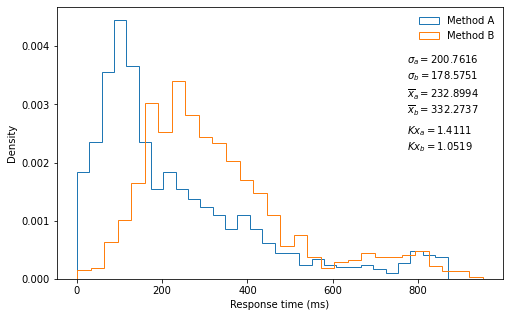

In [152]:
res_a1 = A_method_latency
res_b1 = B_method_latency

latex_std = '\n'.join((
    r'$\sigma_a=%.4f$' % (np.std(res_a1)),
    r'$\sigma_b=%.4f$' % (np.std(res_b1))
))

latex_mean = '\n'.join((
    r'$\overline{x}_a=%.4f$' % (np.mean(res_a1)),
    r'$\overline{x}_b=%.4f$' % (np.mean(res_b1))
))

latex_kurtosis = '\n'.join((
    r'$K{x}_a=%.4f$' % (kurtosis(res_a1)),
    r'$K{x}_b=%.4f$' % (kurtosis(res_b1))
))




plt.figure(figsize=(8, 5))

plt.hist(res_a1, bins=30, density=True, histtype='step', label='Method A')
plt.hist(res_b1, bins=30, density=True, histtype='step', label='Method B')
plt.legend(loc='upper right', frameon=False)
plt.text(0.05, 0.71, latex_std, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.05, 0.58, latex_mean, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.05, 0.45, latex_kurtosis, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.ylabel('Density')
plt.xlabel('Response time (ms)')
# plt.text(0.5, -0.25, '$\sum_{j=0}^{+\infty} A_{j}$', ha='center')
plt.savefig('AB_Histogram.png')
plt.show()

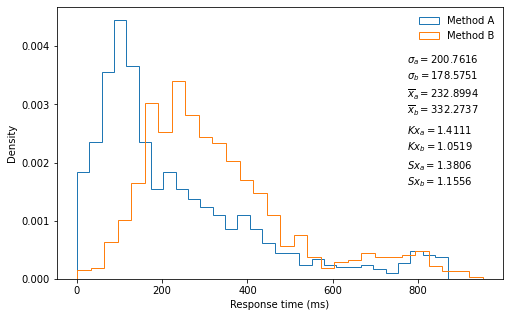

In [153]:
res_a1 = A_method_latency
res_b1 = B_method_latency

latex_std = '\n'.join((
    r'$\sigma_a=%.4f$' % (np.std(res_a1)),
    r'$\sigma_b=%.4f$' % (np.std(res_b1))
))

latex_mean = '\n'.join((
    r'$\overline{x}_a=%.4f$' % (np.mean(res_a1)),
    r'$\overline{x}_b=%.4f$' % (np.mean(res_b1))
))

latex_kurtosis = '\n'.join((
    r'$K{x}_a=%.4f$' % (kurtosis(res_a1)),
    r'$K{x}_b=%.4f$' % (kurtosis(res_b1))
))

latex_skew = '\n'.join((
    r'$S{x}_a=%.4f$' % (skew(res_a1)),
    r'$S{x}_b=%.4f$' % (skew(res_b1))
))


plt.figure(figsize=(8, 5))

plt.hist(res_a1, bins=30, density=True, histtype='step', label='Method A')
plt.hist(res_b1, bins=30, density=True, histtype='step', label='Method B')
plt.legend(loc='upper right', frameon=False)
plt.text(0.05, 0.71, latex_std, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.05, 0.58, latex_mean, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.05, 0.45, latex_kurtosis, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.05, 0.32, latex_skew, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'))
plt.ylabel('Density')
plt.xlabel('Response time (ms)')
# plt.text(0.5, -0.25, '$\sum_{j=0}^{+\infty} A_{j}$', ha='center')
plt.savefig('AB_Histogram.png')
plt.show()

# Két másik mlp model A és B összehasonlítása a hibák alapján.



In [79]:

print(A_model_error.shape)
print(A_model_error_normalized.shape)
print(A_model_predicted_y_normalized.shape)
print(A_model_predicted_y.shape)
print(A_model_y.shape)
print(A_model_y_normalized.shape)

print(B_model_error.shape)
print(B_model_error_normalized.shape)
print(B_model_predicted_y_normalized.shape)
print(B_model_predicted_y.shape)
print(B_model_y.shape)
print(B_model_y_normalized.shape)


(602,)
(602,)
(602,)
(602,)
(602,)
(602,)
(603,)
(603,)
(603,)
(603,)
(603,)
(603,)


# Linear Regression

Kitekintés - Numpy

In [63]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

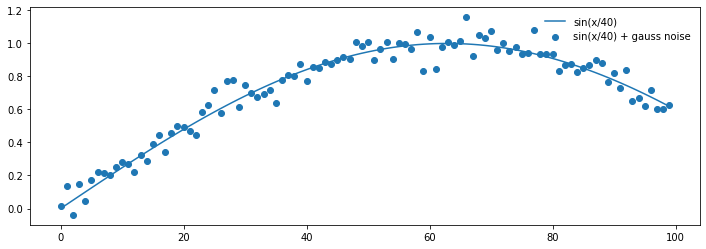

In [64]:
x_val = np.arange(0, 100, 1)

y_val = np.sin(x_val/40)

s_val = y_val + np.random.normal(0, 0.05, x_val.size)

plt.figure(figsize=(12, 4))
plt.plot(x_val, y_val, label = 'sin(x/40)')
plt.scatter(x_val, s_val, label = 'sin(x/40) + gauss noise')
plt.legend(frameon=False)
plt.show()

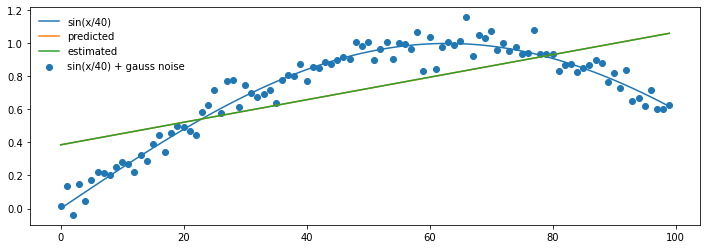

In [65]:
regression_1 = LinearRegression()

regression_1.fit(x_val.reshape(-1,1), s_val)

predicted_val = regression_1.predict(x_val.reshape(-1,1))

estimated_val = regression_1.intercept_ + regression_1.coef_[0] * x_val

plt.figure(figsize=(12, 4))
plt.plot(x_val, y_val, label = 'sin(x/40)')
plt.plot(x_val, predicted_val, label = 'predicted')
plt.plot(x_val, estimated_val, label = 'estimated')
plt.scatter(x_val, s_val, label = 'sin(x/40) + gauss noise')
plt.legend(frameon=False)
plt.show()

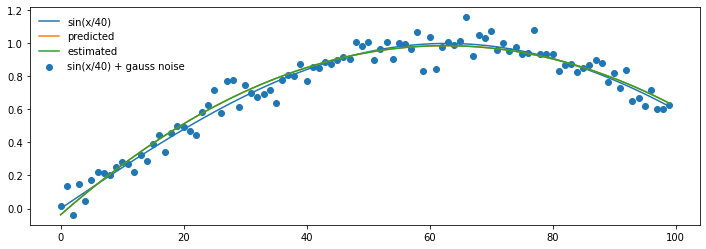

In [66]:
X_mat = np.array([x_val, x_val**2]).T

regression_2 = LinearRegression()

regression_2.fit(X_mat, s_val)

predicted_val = regression_2.predict(X_mat)

estimated_val = regression_2.intercept_ + np.sum(regression_2.coef_ * X_mat, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(x_val, y_val, label = 'sin(x/40)')
plt.plot(x_val, predicted_val, label = 'predicted')
plt.plot(x_val, estimated_val, label = 'estimated')
plt.scatter(x_val, s_val, label = 'sin(x/40) + gauss noise')
plt.legend(frameon=False)
plt.show()

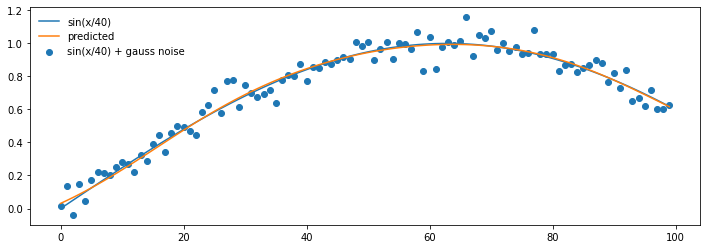

In [67]:
X_val = x_val.reshape(-1, 1)

X_val = X_val/X_val.max()

mlp_val = MLPRegressor(hidden_layer_sizes = (3, 3),
                   shuffle=False,
                   tol = 0.01,                                    # Ez a két paraméter különösen veszélyes, mert idő előtt leállítják a tanulást
                   momentum = 0.1,
                   nesterovs_momentum = True,
                   n_iter_no_change = 1000,                       # Ez a két paraméter különösen veszélyes, mert idő előtt leállítják a tanulást
                   # max_fun = 1000,
                   activation = 'logistic',
                   solver = 'adam',
                   random_state = 1,
                   learning_rate_init = 0.3,
                   max_iter = 2000000)


mlp_val.fit(X_val, y_val)

predicted_val = mlp_val.predict(X_val)

plt.figure(figsize=(12, 4))
plt.plot(x_val, y_val, label = 'sin(x/40)')
plt.plot(x_val, predicted_val, label = 'predicted')
plt.scatter(x_val, s_val, label = 'sin(x/40) + gauss noise')
plt.legend(frameon=False)
plt.show()

## Histogramm (from Loren)

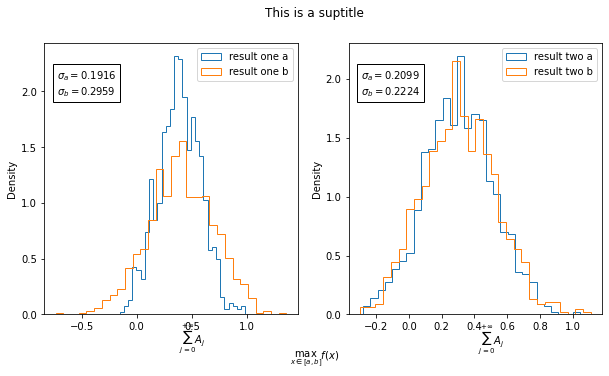

In [ ]:
res_a1 = 0.2 * np.random.randn(1000) + 0.4
res_b1 = 0.3 * np.random.randn(1000) + 0.4
res_a2 = 0.21 * np.random.randn(1000) + 0.3
res_b2 = 0.22 * np.random.randn(1000) + 0.3

latextext1 = '\n'.join((
    r'$\sigma_a=%.4f$' % (np.std(res_a1)),
    r'$\sigma_b=%.4f$' % (np.std(res_b1))
))

latextext2 = '\n'.join((
    r'$\sigma_a=%.4f$' % (np.std(res_a2)),
    r'$\sigma_b=%.4f$' % (np.std(res_b2))
))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(res_a1, bins=30, density=True, histtype='step', label='result one a')
ax.hist(res_b1, bins=30, density=True, histtype='step', label='result one b')
ax.legend(loc='upper right')
ax.text(0.05, 0.81, latextext1, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylabel('Density')
ax.text(0.5, -0.25, '$\sum_{j=0}^{+\infty} A_{j}$', ha='center')

ax = axes[1]
ax.hist(res_a2, bins=30, density=True, histtype='step', label='result two a')
ax.hist(res_b2, bins=30, density=True, histtype='step', label='result two b')
ax.legend(loc='upper right')
ax.text(0.05, 0.81, latextext2, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylabel('Density')
ax.text(0.5, -0.25, '$\sum_{j=0}^{+\infty} A_{j}$', ha='center')

fig.suptitle('This is a suptitle')
fig.text(0.5, -0.0, '$\max_{x \in [a,b]}f(x)$', ha='center')
plt.show()

# Max : $$\max_{x \in [a,b]}f(x)$$

# https://towardsdatascience.com/write-markdown-latex-in-the-jupyter-notebook-10985edb91fd